In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pd.set_option('age_lower_threshold.max_columns', None)
import os

## Clean data

In [99]:
customers=pd.read_csv('ds_customers.csv')
merchants=pd.read_csv('ds_merchants.csv')
transactions=pd.read_csv('ds_transactions.csv')

In [100]:
transactions.head()

,transaction_id,customer_id,transaction_timestamp,transaction_amount,transaction_type,payment_method,account_balance_before,account_balance_after,transaction_device,ip_address,user_agent,is_fraud,merchant_id
0,1,115,2022-12-21,392.44,transfer,debit card,7032.36,7424.80,tablet,7.53.209.71,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,1,NaN
1,2,2395,2021-12-11,594.18,deposit,debit card,11503.03,12097.21,mobile,108.229.29.188,Mozilla/5.0 (X11; Linux x86_64; rv:1.9.6.20) G...,0,NaN
2,3,2082,2022-04-11,6363.16,transfer,credit card,16073.25,22436.41,desktop,148.218.101.152,Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10_9_1...,1,NaN
3,4,315,2022-09-24,2834.45,deposit,debit card,16938.44,19772.89,mobile,14.38.239.68,Mozilla/5.0 (Windows 98) AppleWebKit/533.1 (KH...,0,NaN
4,5,2055,2021-08-11,4117.41,deposit,credit card,8686.47,12803.88,desktop,1.93.31.164,Mozilla/5.0 (X11; Linux i686; rv:1.9.7.20) Gec...,0,NaN


In [101]:
customers.head()

,customer_id,account_age,customer_demographics
0,1,1641,NaN
1,2,829,NaN
2,3,154,NaN
3,4,440,NaN
4,5,1221,NaN


In [102]:
merchants.head()

,merchant_id,merchant_category
0,1,clothing
1,2,electronics
2,3,travel
3,4,health
4,5,electronics


In [103]:
data=transactions.merge(customers,on='customer_id',how='left').merge(merchants,on='merchant_id',how='left')

In [104]:
#lower cate var
data['transaction_type']=data['transaction_type'].str.lower()
data['payment_method']=data['payment_method'].str.lower()
data['transaction_device']=data['transaction_device'].str.lower()

In [105]:
data['transaction_amt']=data['account_balance_after']-data['account_balance_before']

In [107]:
from ua_parser import user_agent_parser
data['OS']=data['user_agent'].apply(lambda x: user_agent_parser.Parse(x)['os']['family'])
data['device']=data['user_agent'].apply(lambda x: user_agent_parser.Parse(x)['device']['family'])
data['browser']=data['user_agent'].apply(lambda x: user_agent_parser.Parse(x)['user_agent']['family'])

KeyboardInterrupt: 

In [ ]:
data.to_excel('clean_data.xlsx',index=False)

In [ ]:
data.to_csv('clean_data.csv',index=False)

# EDA

In [108]:
df=pd.read_csv('clean_data.csv')

# Cat var

In [109]:
df.customer_demographics.fillna('Missing',inplace=True)

In [110]:
df.columns

Index(['transaction_id', 'customer_id', 'transaction_timestamp',
       'transaction_amount', 'transaction_type', 'payment_method',
       'account_balance_before', 'account_balance_after', 'transaction_device',
       'ip_address', 'user_agent', 'is_fraud', 'merchant_id', 'account_age',
       'customer_demographics', 'merchant_category', 'transaction_amt', 'OS',
       'device', 'browser'],
      dtype='object')

In [111]:
from tabulate import tabulate
cat_cols=['transaction_type', 'payment_method','transaction_device','customer_demographics', 'merchant_category','OS','device', 'browser']
for col in cat_cols:
	result_1d=(df[df.is_fraud==1].groupby(col)['is_fraud'].count()/df.groupby(col)['is_fraud'].count()) .to_frame().reset_index().rename(columns={'is_fraud':'fraud_rate'})
	result_1d=result_1d.merge((df[df.is_fraud==1].groupby(col)['is_fraud'].count()/len(df[df.is_fraud==1])) .to_frame().reset_index().rename(columns={'is_fraud':'coverage'}), how='left', on=col)
	# result_1d=result_1d.merge(df.groupby(col)['is_fraud'].count() .to_frame().reset_index().rename(columns={'is_fraud':'transaction_cnt'}), how='left', on=col)
	print(tabulate(result_1d, headers='keys', tablefmt='psql'))

+----+--------------------+--------------+------------+
|    | transaction_type   |   fraud_rate |   coverage |
|----+--------------------+--------------+------------|
|  0 | deposit            |    0.0500802 |   0.249655 |
|  1 | purchase           |    0.0498462 |   0.248935 |
|  2 | transfer           |    0.0500476 |   0.251075 |
|  3 | withdrawal         |    0.0500298 |   0.250335 |
+----+--------------------+--------------+------------+
+----+------------------+--------------+------------+
|    | payment_method   |   fraud_rate |   coverage |
|----+------------------+--------------+------------|
|  0 | bank transfer    |    0.049595  |   0.330873 |
|  1 | credit card      |    0.0503823 |   0.335813 |
|  2 | debit card       |    0.0500261 |   0.333313 |
+----+------------------+--------------+------------+
+----+----------------------+--------------+------------+
|    | transaction_device   |   fraud_rate |   coverage |
|----+----------------------+--------------+------------|


In [113]:
from itertools import combinations
combination2 = list(combinations(cat_cols,2))
result_2d_combined=pd.DataFrame()
for cols in combination2:
	col=list(cols)
	result_2d=(df[df.is_fraud==1].groupby(col)['is_fraud'].count()/df.groupby(col)['is_fraud'].count()) .to_frame().reset_index().rename(columns={'is_fraud':'fraud_rate'})
	result_2d=result_2d.merge((df[df.is_fraud==1].groupby(col)['is_fraud'].count()/len(df[df.is_fraud==1])).to_frame().reset_index().rename(columns={'is_fraud':'coverage'}), how='left', on=col)
	# result_2d=result_2d.merge(df.groupby(col)['is_fraud'].count() .to_frame().reset_index().rename(columns={'is_fraud':'transaction_cnt'}), how='left', on=col)
	print(tabulate(result_2d, headers='keys', tablefmt='psql'))

+----+--------------------+------------------+--------------+------------+
|    | transaction_type   | payment_method   |   fraud_rate |   coverage |
|----+--------------------+------------------+--------------+------------|
|  0 | deposit            | bank transfer    |    0.0503363 |  0.0835183 |
|  1 | deposit            | credit card      |    0.049895  |  0.0831183 |
|  2 | deposit            | debit card       |    0.0500102 |  0.0830183 |
|  3 | purchase           | bank transfer    |    0.0482974 |  0.0802184 |
|  4 | purchase           | credit card      |    0.0507215 |  0.0844983 |
|  5 | purchase           | debit card       |    0.0505146 |  0.0842183 |
|  6 | transfer           | bank transfer    |    0.0496346 |  0.0835383 |
|  7 | transfer           | credit card      |    0.0499838 |  0.0831383 |
|  8 | transfer           | debit card       |    0.0505274 |  0.0843983 |
|  9 | withdrawal         | bank transfer    |    0.0501097 |  0.0835983 |
| 10 | withdrawal        

## Numerical var

In [114]:
# df['transaction_amt_group']= pd.qcut(df.transaction_amount, q=10)
df['abs_transaction_amt']= df.transaction_amt.abs()
# df['abs_transaction_amt_group']= pd.qcut(df.abs_transaction_amt, q=10)

In [155]:
# pd.set_option('display.max_rows', None)

## For >0 transaction amount

In [116]:
df.loc[df.transaction_amt>0,'transaction_amt'].describe(percentiles=[0.9,0.95,0.96,0.97,0.98,0.99,0.997,0.999])

count    499970.000000
mean       5115.340374
std        3343.790863
min           1.020000
50%        5029.845000
90%        9051.684000
95%        9551.405500
96%        9654.082400
97%        9755.677900
98%        9856.002400
99%        9956.826200
99.7%     24279.993470
99.9%     35179.540610
max       49297.090000
Name: transaction_amt, dtype: float64

In [117]:
# Alarming threshold for transaction amount
amount=list(range(10000,50000,100))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
transaction_amt_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		transaction_amt_threshold['fraud_rate'].append(len(df.loc[(df.transaction_amt>=amt)&(df.is_fraud==1)])/len(df.loc[(df.transaction_amt>=amt)]))
		transaction_amt_threshold['coverage'].append(len(df.loc[(df.transaction_amt>=amt)&(df.is_fraud==1)])/len(df.loc[(df.is_fraud==1)]))
		transaction_amt_threshold['threshold'].append(amt)
	except:
		continue

transaction_amt_threshold_df=pd.DataFrame.from_dict(transaction_amt_threshold)	
transaction_amt_threshold_df[transaction_amt_threshold_df.fraud_rate>=0.06]

# threshold for transaction_amt

,threshold,fraud_rate,coverage
257,35700,0.061269,0.00056
258,35800,0.062222,0.00056
259,35900,0.062780,0.00056
260,36000,0.063927,0.00056
261,36100,0.064815,0.00056
...,...,...,...
388,48800,0.500000,0.00002
389,48900,1.000000,0.00002
390,49000,1.000000,0.00002
391,49100,1.000000,0.00002


Text(0, 0.5, 'coverage')

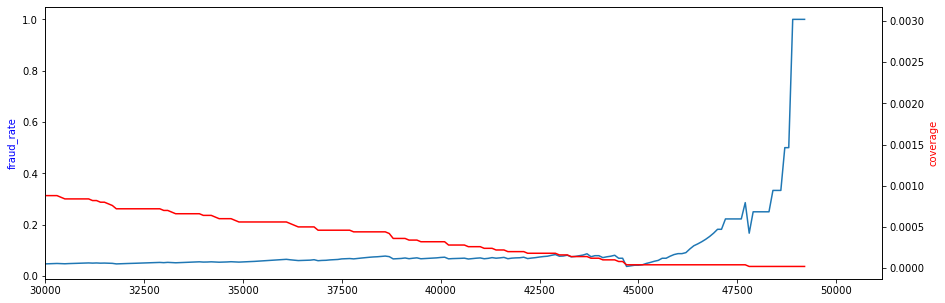

In [118]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax1.plot(transaction_amt_threshold_df.threshold, transaction_amt_threshold_df.fraud_rate)
ax2.plot(transaction_amt_threshold_df.threshold, transaction_amt_threshold_df.coverage,color='r' )
ax1.set_xlim(30000,None)
 
ax1.set_ylabel('fraud_rate', color='b')
ax2.set_ylabel('coverage', color='r')
#Alarming threshold: >= 37500 (maybe try 35000 in scoring)

## For <0 transaction amount

In [119]:
df.loc[df.transaction_amt<0,'transaction_amt'].describe(percentiles=[0.01,0.00998,0.0097,0.0096,0.0095])

count     500030.000000
mean       -5117.591863
std         3341.679151
min       -49858.620000
0.95%      -9961.700000
0.96%      -9960.770000
0.97%      -9959.590000
0.998%     -9956.494212
1%         -9956.365500
50%        -5031.395000
max           -1.010000
Name: transaction_amt, dtype: float64

In [120]:
len(df.loc[(df.transaction_amt<=-20000)&(df.is_fraud==1)])/len(df.loc[(df.transaction_amt<=-20000)])

0.04779411764705882

In [121]:
# Alarming threshold for transaction amount
amount=list(range(-10000,-50000,-100))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
transaction_neg_amt_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		transaction_neg_amt_threshold['fraud_rate'].append(len(df.loc[(df.transaction_amt<=amt)&(df.is_fraud==1)])/len(df.loc[(df.transaction_amt<=amt)]))
		transaction_neg_amt_threshold['coverage'].append(len(df.loc[(df.transaction_amt<=amt)&(df.is_fraud==1)])/len(df.loc[(df.is_fraud==1)]))
		transaction_neg_amt_threshold['threshold'].append(amt)
	except:
		continue

transaction_neg_amt_threshold_df=pd.DataFrame.from_dict(transaction_neg_amt_threshold)	

# threshold for transaction_amt

In [122]:
transaction_neg_amt_threshold_df[transaction_neg_amt_threshold_df.fraud_rate>=0.055]

,threshold,fraud_rate,coverage
371,-47100,0.058824,0.00002
372,-47200,0.062500,0.00002
373,-47300,0.062500,0.00002
374,-47400,0.071429,0.00002
375,-47500,0.090909,0.00002
376,-47600,0.090909,0.00002
377,-47700,0.111111,0.00002
378,-47800,0.125000,0.00002
379,-47900,0.125000,0.00002
380,-48000,0.142857,0.00002


Text(0, 0.5, 'coverage')

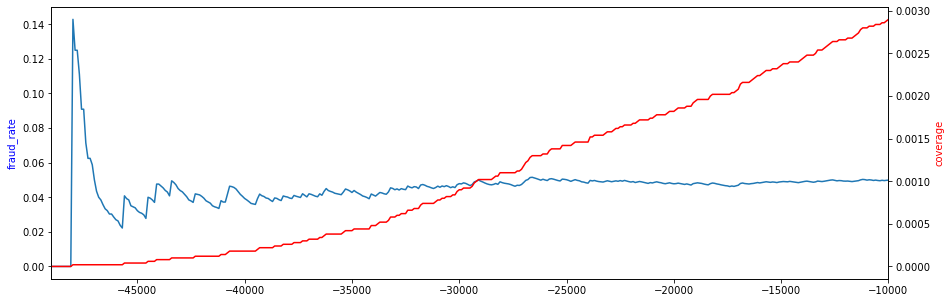

In [123]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15,5))

ax2 = ax1.twinx()
ax1.plot(transaction_neg_amt_threshold_df.threshold, transaction_neg_amt_threshold_df.fraud_rate)
ax2.plot(transaction_neg_amt_threshold_df.threshold, transaction_neg_amt_threshold_df.coverage,color='r' )

ax1.set_xlim(-49000,-10000)
ax1.set_ylabel('fraud_rate', color='b')
ax2.set_ylabel('coverage', color='r')
#Alarming threshold: >= -47000 (maybe try -40000 in scoring)

## Check if an IP is linked to many users --> might be fraud

In [124]:
df.columns

Index(['transaction_id', 'customer_id', 'transaction_timestamp',
       'transaction_amount', 'transaction_type', 'payment_method',
       'account_balance_before', 'account_balance_after', 'transaction_device',
       'ip_address', 'user_agent', 'is_fraud', 'merchant_id', 'account_age',
       'customer_demographics', 'merchant_category', 'transaction_amt', 'OS',
       'device', 'browser', 'abs_transaction_amt'],
      dtype='object')

In [125]:
ip_data=df.groupby('ip_address')['customer_id'].nunique().to_frame().reset_index().rename(columns={'customer_id':'customer_w_same_ip_cnt'})

df=df.merge(ip_data,how='left',on='ip_address')

In [126]:
print('fraud rate: ',len(df.loc[(df.customer_w_same_ip_cnt>1)&(df.is_fraud==1)])/len(df.loc[(df.customer_w_same_ip_cnt>1)]))
print('coverage: ',(len(df.loc[(df.customer_w_same_ip_cnt>1)&(df.is_fraud==1)])/len(df.loc[(df.is_fraud==1)])))

fraud rate:  0.059602649006622516
coverage:  0.0003599928001439971


## Check abnormal total amt/ total transactions per day per customer

In [127]:
num_trans_data=df.groupby(['customer_id','transaction_timestamp']).agg({'transaction_id':pd.Series.nunique, 
                         'abs_transaction_amt':sum,
                         'is_fraud': sum}).reset_index().rename(columns={'transaction_id':'transaction_cnt/day/cus','abs_transaction_amt':'abs_transaction_amt/day/cus','is_fraud':'fraud_cnt/day/cus'})


In [128]:
num_trans_data.describe()

,customer_id,transaction_cnt/day/cus,abs_transaction_amt/day/cus,fraud_cnt/day/cus
count,768299.000000,768299.000000,768299.000000,768299.000000
mean,1250.505181,1.296680,6634.152119,0.064843
std,722.019191,0.565758,4780.353165,0.249661
min,1.000000,1.000000,1.020000,0.000000
25%,625.000000,1.000000,3197.470000,0.000000
50%,1250.000000,1.000000,6156.320000,0.000000
75%,1876.000000,1.000000,8898.135000,0.000000
max,2500.000000,7.000000,76504.240000,3.000000


In [129]:
num_trans_data.describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,0.99])

,customer_id,transaction_cnt/day/cus,abs_transaction_amt/day/cus,fraud_cnt/day/cus
count,768299.000000,768299.000000,768299.000000,768299.000000
mean,1250.505181,1.296680,6634.152119,0.064843
std,722.019191,0.565758,4780.353165,0.249661
min,1.000000,1.000000,1.020000,0.000000
25%,625.000000,1.000000,3197.470000,0.000000
50%,1250.000000,1.000000,6156.320000,0.000000
75%,1876.000000,1.000000,8898.135000,0.000000
80%,2001.000000,2.000000,9421.028000,0.000000
90%,2251.000000,2.000000,12168.192000,0.000000
95%,2376.000000,2.000000,15344.122000,1.000000


In [130]:
df=df.merge(num_trans_data,how='left',on=['customer_id','transaction_timestamp'])

In [131]:
print('fraud rate: ',len(df[(df['transaction_cnt/day/cus']>=7)&(df.is_fraud==1)])/len(df[df['transaction_cnt/day/cus']>=7]) )
print('coverage: ',len(df[(df['transaction_cnt/day/cus']>=7)&(df.is_fraud==1)])/len(df[df.is_fraud==1]) )

fraud rate:  0.2857142857142857
coverage:  3.999920001599968e-05


In [132]:
# Alarming threshold for number of transaction per day per cus
amount=list(range(0,8))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
transaction_perday_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		transaction_perday_threshold['fraud_rate'].append(len(df[(df['transaction_cnt/day/cus']>=amt)&(df.is_fraud==1)])/len(df[df['transaction_cnt/day/cus']>=amt]))
		transaction_perday_threshold['coverage'].append(len(df[(df['transaction_cnt/day/cus']>=amt)&(df.is_fraud==1)])/len(df[df.is_fraud==1]))
		transaction_perday_threshold['threshold'].append(amt)
	except:
		continue

transaction_perday_threshold_df=pd.DataFrame.from_dict(transaction_perday_threshold)	

In [133]:
transaction_perday_threshold_df #no special threshold

,threshold,fraud_rate,coverage
0,0,0.050007,0.996360
1,1,0.050007,0.996360
2,2,0.049952,0.417892
3,3,0.049979,0.103218
4,4,0.051784,0.018140
5,5,0.051108,0.002260
6,6,0.044199,0.000160
7,7,0.285714,0.000040


In [134]:
print('fraud rate: ',len(df[(df['abs_transaction_amt/day/cus']>=50000)&(df.is_fraud==1)])/len(df[df['abs_transaction_amt/day/cus']>=50000]) )
print('coverage: ',len(df[(df['abs_transaction_amt/day/cus']>=50000)&(df.is_fraud==1)])/len(df[df.is_fraud==1]) )

fraud rate:  0.05737704918032787
coverage:  0.00041999160016799666


In [135]:
# Alarming threshold for number of transaction abs_transaction_amt/day/cus
amount=list(range(20000,80000,100))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
abs_amt_perday_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		abs_amt_perday_threshold['fraud_rate'].append(len(df[(df['abs_transaction_amt/day/cus']>=amt)&(df.is_fraud==1)])/len(df[df['abs_transaction_amt/day/cus']>=amt]))
		abs_amt_perday_threshold['coverage'].append(len(df[(df['abs_transaction_amt/day/cus']>=amt)&(df.is_fraud==1)])/len(df[df.is_fraud==1]))
		abs_amt_perday_threshold['threshold'].append(amt)
	except:
		continue

abs_amt_perday_threshold_df=pd.DataFrame.from_dict(abs_amt_perday_threshold)	

In [136]:
abs_amt_perday_threshold_df[abs_amt_perday_threshold_df.fraud_rate>=0.056]
#Alarming threshold: >= 47000-50000

,threshold,fraud_rate,coverage
277,47700,0.056777,0.00062
278,47800,0.056604,0.00060
289,48900,0.056604,0.00048
290,49000,0.057279,0.00048
291,49100,0.057831,0.00048
...,...,...,...
561,76100,0.333333,0.00002
562,76200,0.333333,0.00002
563,76300,0.333333,0.00002
564,76400,0.333333,0.00002


## Check account age

In [137]:
df.account_age.describe()

count    999613.000000
mean       1012.577735
std         570.544289
min          32.000000
25%         516.000000
50%        1009.000000
75%        1510.000000
max        2000.000000
Name: account_age, dtype: float64

In [138]:
print('fraud rate: ',len(df[(df['account_age']>=1100)&(df.is_fraud==1)])/len(df[df['account_age']>=1100]) )
print('coverage: ',len(df[(df['account_age']>=1100)&(df.is_fraud==1)])/len(df[df.is_fraud==1]) )

fraud rate:  0.050237844310848045
coverage:  0.45475090498190035


In [139]:
# Alarming threshold for account age (<=)
amount=list(range(30,2000,10))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
age_lower_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		age_lower_threshold['fraud_rate'].append(len(df[(df['account_age']<=amt)&(df.is_fraud==1)])/len(df[df['account_age']<=amt]))
		age_lower_threshold['coverage'].append(len(df[(df['account_age']<=amt)&(df.is_fraud==1)])/len(df[df.is_fraud==1]))
		age_lower_threshold['threshold'].append(amt)
	except:
		continue

age_lower_threshold_df=pd.DataFrame.from_dict(age_lower_threshold)	

In [140]:
age_lower_threshold_df[age_lower_threshold.fraud_rate>=0.051]
#try account age <=70

AttributeError: 'dict' object has no attribute 'fraud_rate'

## Scoring
When a user meets a feature +1 point for fraud potential (feature with fraud rate >= 5.x%)

Might-be-fraudulent transactions patterns:
1. Transaction amount >=35000 or <=-40000 OR Total absolute transaction amount per day per user >= 47000
2. The IP address is shared with >=2 users
4. Browser: Other
5. Device: LG UG, XiaoMi MI-NZ
6. Account age <= 70
7. OS: Other 
8. Other combinations that have high fraud rate:
	(clothing/entertainment/travel - Generic Tablet)
	OR (mobile - Generic Tablet)
	OR (health - Android)
	OR (clothing - iPhone)

In [157]:
df['point']=0
# replace Na with '' for category
df.merchant_category.fillna('',inplace=True)
for index, row in df.iterrows():
    point=0
    if row['transaction_amt']>=30000 or row['transaction_amt']<=-40000 or row['abs_transaction_amt/day/cus']<=-30000:
        point+=1
        # print(point)
    if row['customer_w_same_ip_cnt']>=2:
        point+=1
        # print(point)
    if row['browser']=='Other':
        point+=1
        # print(point)
    if row['device'] in ('LG UG','XiaoMi MI-NZ'):
        point+=1
        # print(point)
    if row['account_age']<=70:
        point+=1
        # print(point)
    if row['OS'] == 'Other':
        point+=1
        # print(point)
    if row['merchant_category'] in ('clothing','entertainment','travel') and row['device']=='Generic Tablet':
        point+=1
        # print(point)
    if row['transaction_device'] in ('mobile') and row['device']=='Generic Tablet':
        point+=1
        # print(point)
    if row['merchant_category'] in ('health') and row['OS']=='Android':
        point+=1
        # print(point)
    if row['merchant_category'] in ('clothing') and row['device']=='iPhone':
        point+=1
        # print(point)
    df.loc[index,'point']=point

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [161]:
df.point.unique()

array([0, 1, 3, 2, 4], dtype=int64)

In [162]:
amount=list(range(1,5))
lkey = ['threshold','fraud_rate','coverage'] #fraud rate: precision; coverage: recall
point_threshold={key: [] for key in lkey}

for amt in amount:
	try:
		point_threshold['fraud_rate'].append(len(df[(df.point>=amt)&(df.is_fraud==1)])/len(df[df.point>=amt]))
		point_threshold['coverage'].append(len(df[(df.point>=amt)&(df.is_fraud==1)])/len(df[df.is_fraud==1]))
		point_threshold['threshold'].append(amt)
	except:
		continue

point_threshold_df=pd.DataFrame.from_dict(point_threshold)	

In [164]:
point_threshold_df
# df[(df.point>=3)&(df.is_fraud==1)]

,threshold,fraud_rate,coverage
0,1,0.051637,0.125557
1,2,0.057501,0.009920
2,3,0.052632,0.000220
3,4,0.000000,0.000000


In [165]:
# current fraud rate
len(df[df.is_fraud==1])/len(df)

0.050001

### **Point to choose: >=2**
Increase fraud rate by 0.007
Coverage 0.9%
--> Most fraudulent transactions are still not detected --> Suggest adding variables

Might-be useful vars:
- User demographics (most users now dont have this)
- User phone (phone number, telcom_provider)
- transaction timestamp in seconds
- transaction locations